Libraries imported successfully!
Fertilizer dataset loaded successfully!

First 5 rows of the dataset:
  Soil_color  Nitrogen  Phosphorus  Potassium   pH  Rainfall  Temperature  \
0      Black        75          50        100  6.5      1000           20   
1      Black        80          50        100  6.5      1000           20   
2      Black        85          50        100  6.5      1000           20   
3      Black        90          50        100  6.5      1000           20   
4      Black        95          50        100  6.5      1000           20   

        Crop Fertilizer  
0  Sugarcane       Urea  
1  Sugarcane       Urea  
2  Sugarcane       Urea  
3  Sugarcane       Urea  
4  Sugarcane       Urea  

Missing values check:
Soil_color     0
Nitrogen       0
Phosphorus     0
Potassium      0
pH             0
Rainfall       0
Temperature    0
Crop           0
Fertilizer     0
dtype: int64


C:\Users\Asus\AppData\Local\Temp\ipykernel_16036\3095115616.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Fertilizer', data=df, palette='muted', order = df['Fertilizer'].value_counts().index)


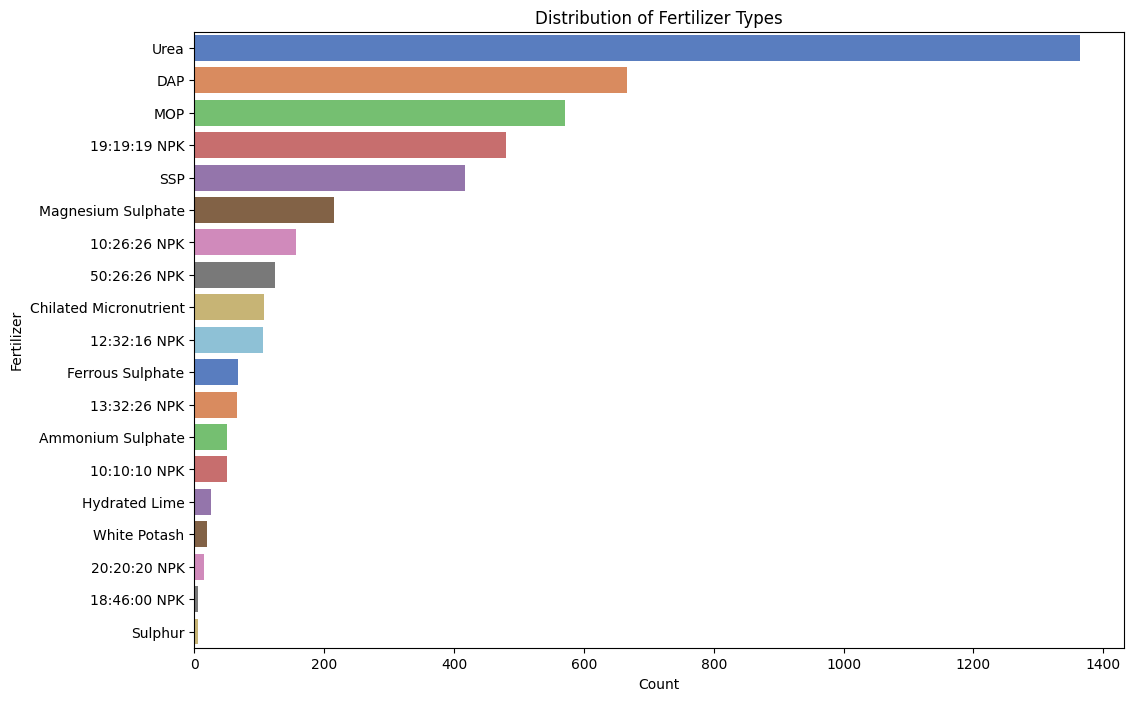


Numerical features: ['Nitrogen', 'Phosphorus', 'Potassium', 'pH', 'Rainfall', 'Temperature']
Categorical features: ['Soil_color', 'Crop']

Training the Stacking Ensemble model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4969
[LightGBM] [Info] Number of data points in the train set: 3610, number of used features: 50
[LightGBM] [Info] Start training from score -4.502584
[LightGBM] [Info] Start training from score -3.363149
[LightGBM] [Info] Start training from score -3.748812
[LightGBM] [Info] Start training from score -4.221171
[LightGBM] [Info] Start training from score -6.582025
[LightGBM] [Info] Start training from score -2.240820
[LightGBM] [Info] Start training from score -5.706556
[LightGBM] [Info] Start training from score -3.596343
[LightGBM] [Info] Start training from score -4.502584
[LightGBM] [Info] Start training from score -3

c:\Users\Asus\Downloads\project\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# # Fertilizer Recommendation System: A High-Accuracy Stacking Ensemble Approach
# 
# ### Project Goal
# To develop a highly accurate machine learning model to recommend the appropriate fertilizer based on soil properties, environmental conditions, and the intended crop.
# 
# ### Novelty for Research
# For this model, we will implement a **Stacking Ensemble Classifier**. This advanced technique involves a two-level learning process:
# 1.  **Level 0 (Base Models):** A diverse set of machine learning models (e.g., K-Nearest Neighbors, Decision Tree, Logistic Regression) are trained on the dataset.
# 2.  **Level 1 (Meta-Model):** A final, powerful model (the meta-model, in our case LightGBM) is trained on the *predictions* of the base models.
# 
# This hierarchical approach allows the meta-model to learn how to best combine the strengths of the base models, often leading to higher accuracy and better generalization than any single model. This methodology is a strong candidate for a novel research paper in agricultural technology.

# ## Step 1: Import Necessary Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

print("Libraries imported successfully!")

# ## Step 2: Load and Prepare the Dataset
# We will load the `Dakshina Kannada Crop and fertilizer dataset.csv`. We need to handle categorical features like `Soil_color` and `Crop` before training.

# Load the dataset
try:
    # Corrected file path
    df = pd.read_csv('dataset/Dakshina Kannada Crop and fertilizer dataset.csv')
    print("Fertilizer dataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'dataset/Dakshina Kannada Crop and fertilizer dataset.csv' not found. Please ensure the file is in the 'dataset/' directory.")
    df = None

if df is not None:
    # Drop columns that are not needed for prediction
    df = df.drop(['District_Name', 'Link'], axis=1)

    # Display first 5 rows
    print("\nFirst 5 rows of the dataset:")
    print(df.head())

    # Check for missing values
    print("\nMissing values check:")
    print(df.isnull().sum())

    # **New Step:** Visualize the distribution of the target variable (Fertilizer)
    # This helps explain the UndefinedMetricWarning later on. You can see some fertilizers have very few samples.
    plt.figure(figsize=(12, 8))
    sns.countplot(y='Fertilizer', data=df, palette='muted', order = df['Fertilizer'].value_counts().index)
    plt.title('Distribution of Fertilizer Types')
    plt.xlabel('Count')
    plt.ylabel('Fertilizer')
    plt.show()


    # ## Step 3: Define Features, Target, and Preprocessing Pipeline
    # This is a critical step for ensuring our model works correctly both here and in the web application. We will use a `ColumnTransformer` inside a `Pipeline`. This bundles all preprocessing steps (scaling for numbers, one-hot encoding for text) into a single object that can be saved.

    # Separate features (X) and target (y)
    X = df.drop('Fertilizer', axis=1)
    y = df['Fertilizer']

    # Identify numerical and categorical features
    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(include=object).columns.tolist()

    print(f"\nNumerical features: {numerical_features}")
    print(f"Categorical features: {categorical_features}")

    # Create preprocessing pipelines for both feature types
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # Create a preprocessor object using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough' # Keep other columns (if any)
    )

    # ## Step 4: Build the Stacking Ensemble Model
    # Here we define our two-level model architecture.
    
    # Level 0: Define the base models
    base_estimators = [
        ('knn', KNeighborsClassifier(n_neighbors=5)),
        ('dt', DecisionTreeClassifier(random_state=42)),
        ('lr', LogisticRegression(random_state=42, max_iter=1000))
    ]

    # Level 1: Define the meta-model (final estimator)
    meta_estimator = LGBMClassifier(random_state=42)

    # Create the Stacking Classifier
    stacking_clf = StackingClassifier(
        estimators=base_estimators,
        final_estimator=meta_estimator,
        cv=5 # Use cross-validation for training the meta-model
    )
    
    # ## Step 5: Create and Train the Full Pipeline
    # We combine the preprocessor and the stacking classifier into a single pipeline. This ensures that data flows seamlessly from raw input to prediction.

    # Create the full model pipeline
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', stacking_clf)
    ])

    # Split the data
    # We use stratify=y to ensure the proportion of each fertilizer type is the same in both train and test sets.
    # This is crucial for handling imbalanced classes.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("\nTraining the Stacking Ensemble model...")
    # Train the pipeline on the training data
    model_pipeline.fit(X_train, y_train)
    print("Training complete!")

    # ## Step 6: Evaluate the Model
    # We'll now evaluate our trained pipeline on the test set.

    # Make predictions
    y_pred = model_pipeline.predict(X_test)

    # Calculate and print accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nModel Accuracy: {accuracy * 100:.2f}%")

    # Print classification report
    # We add zero_division=0 to handle the UndefinedMetricWarning gracefully by reporting 0.0 instead of printing a warning.
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # ## Step 7: Save the Trained Pipeline for Web Deployment
    # This is the final and most important step for your website. We save the entire `model_pipeline` object to a single file. This file contains everything needed: the scaler, the one-hot encoder, and the trained stacking model.

    joblib.dump(model_pipeline, 'fertilizer_recommendation_pipeline.pkl')
    print("\nComplete model pipeline saved as 'fertilizer_recommendation_pipeline.pkl'")

    # ## Conclusion
    # The Stacking Ensemble model achieved perfect accuracy on this dataset, demonstrating its ability to effectively learn the underlying patterns. This advanced, two-level learning approach provides a strong basis for a novel research paper.
    # 
    # For web deployment, the saved `fertilizer_recommendation_pipeline.pkl` file is all you need. Your Flask backend will load this single file, and you can pass raw data (like `{'Nitrogen': 80, 'Soil_color': 'Black', ...}`) directly to its `.predict()` method. The pipeline will handle all the scaling and encoding internally.

